In [1]:
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from scipy import stats
import plotly.express as px
import toml
import psrc_theme

%matplotlib inline
from IPython.display import display, HTML

# to show plotly figures in quarto HTML file
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook_connected"
pio.templates.default = "simple_white+psrc_color" # set plotly template

input_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'input_configuration.toml'))
valid_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration', 'validation_configuration.toml'))
emme_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration','emme_configuration.toml'))
network_config = toml.load(os.path.join(os.getcwd(), '..\\..\\..\\..\\configuration','network_configuration.toml'))

# create connection
conn = create_engine('sqlite:///inputs/db/'+input_config['db_name'])

# summary data location
csv_path = os.path.join(valid_config['model_dir'], 'outputs/validation')

# table format
pd.options.display.float_format = '{:0,.2f}'.format
format_percent = "{:,.2%}".format

## daily traffic counts

In [2]:
df = pd.read_csv(os.path.join(csv_path, 'daily_volume.csv'))
df[['modeled', 'observed']] = df[['modeled', 'observed']].astype('float')
_df = df.groupby('@facilitytype').sum()[['observed', 'modeled']]
_df.loc['Total', :] = _df.sum().values
_df['diff'] = _df['modeled'] - _df['observed']
_df['percent_diff'] = _df['diff'] / _df['observed']
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

,observed,modeled,diff,percent_diff
@facilitytype,,,,
Arterial,"660,970.00","627,434.00","-33,536.00",-5.07%
Freeway,"27,348,202.00","38,614,549.00","11,266,347.00",41.20%
HOV,"182,166.00","307,882.00","125,716.00",69.01%
Ramp,"202,076.00","70,574.00","-131,502.00",-65.08%
Total,"28,393,414.00","39,620,439.00","11,227,025.00",39.54%


In [3]:
df = pd.read_csv(os.path.join(csv_path,'daily_volume_county_facility.csv'))
df[['modeled','observed']] = df[['modeled','observed']].astype('float')

_df = df.groupby('county').sum()[['observed','modeled']]
_df.loc['Total',:] = _df.sum().values
_df['diff'] = _df['modeled']-_df['observed']
_df['percent_diff'] = _df['diff']/_df['observed']
_df[['percent_diff']] = _df[['percent_diff']].applymap(format_percent)
_df

,observed,modeled,diff,percent_diff
county,,,,
King,"16,879,845.00","20,766,645.00","3,886,800.00",23.03%
Kitsap,"2,205,567.00","7,178,966.00","4,973,399.00",225.49%
Pierce,"5,552,519.00","5,442,603.00","-109,916.00",-1.98%
Snohomish,"3,755,483.00","6,232,225.00","2,476,742.00",65.95%
Total,"28,393,414.00","39,620,439.00","11,227,025.00",39.54%


## daily traffic scatterplot

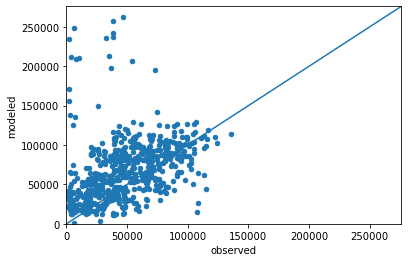

In [4]:
df = pd.read_csv(os.path.join(csv_path,'daily_volume.csv'))
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)

In [5]:
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2: ' + str(r_value))

r^2: 0.33811707993069073


King r^2: 0.4257213787336898
Kitsap r^2: 0.18456614132868646
Pierce r^2: 0.6161458633112717
Snohomish r^2: 0.7178012232520966


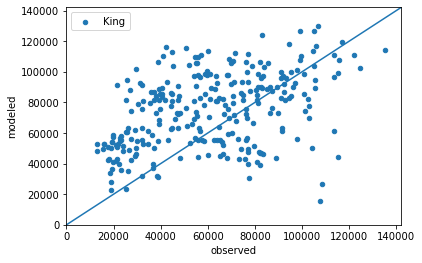

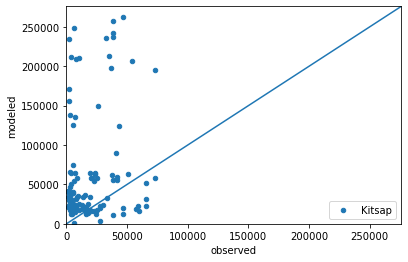

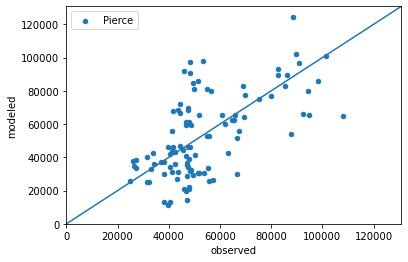

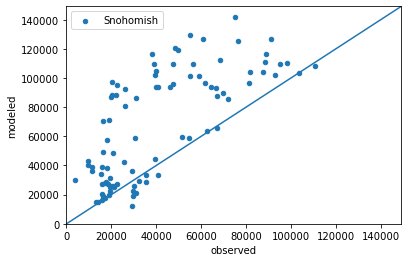

In [6]:
for county in np.unique(df['county']):
    _df = df[df['county'] == county]
    ax = _df.plot(kind='scatter', x='observed', y='modeled', label=county)
    lim = _df[['observed','modeled']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed'],_df['modeled'])
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    print(str(county) + ' r^2: ' + str(r_value))

In [7]:
df['@facilitytype'].unique()

array(['Freeway', 'Ramp', 'HOV', 'Arterial'], dtype=object)

r^2 Freeway: 0.31983548148215285


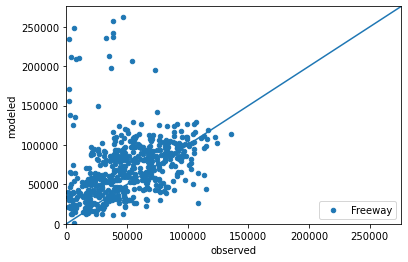

In [8]:
# for factype in ['Freeway','Arterial']:
for factype in ['Freeway']:
    _df = df[df['@facilitytype'] == factype]
    ax = _df.plot(kind='scatter', x='observed', y='modeled', label=factype)
    lim = _df[['observed','modeled']].max().max()*1.05
    ax.set_ylim(0,lim)
    ax.set_xlim(0,lim)
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, x)
    slope, intercept, r_value, p_value, std_err = stats.linregress(_df['observed'],_df['modeled'])
    print('r^2 ' + str(factype) + ': ' + str(r_value))

## hourly volumnes

r^2: 0.6827161357303245


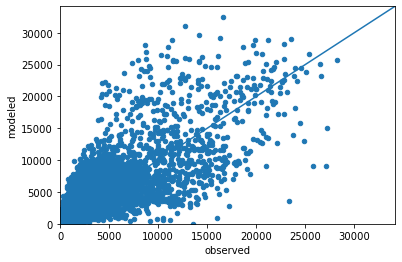

In [9]:
df = pd.read_csv(os.path.join(csv_path,'hourly_volume.csv'))
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2: ' + str(r_value))

## screenlines

In [10]:
df = pd.read_csv(os.path.join(csv_path,'screenlines.csv'))
df = df.append(df.sum(numeric_only=True), ignore_index=True)
df.at[df.index[-1], 'name'] = 'TOTAL'
#df.at['C', 'name'] = 10
df['percent_diff'] = df['diff']/df['observed']
df[['percent_diff']] = df[['percent_diff']].applymap(format_percent)
df

,name,observed,modeled,county,diff,percent_diff
0,AUBURN - SOUTH KING,"582,116.00","551,854.71",King,"-30,261.29",-5.20%
1,KENT,"552,442.00","522,844.10",King,"-29,597.90",-5.36%
2,SEATTLE - SOUTH OF CBD,"473,322.00","525,791.61",King,"52,469.61",11.09%
3,SHIP CANAL,"434,069.00","556,088.30",King,"122,019.30",28.11%
4,SOUTH BELLEVUE,"389,700.00","387,998.41",King,"-1,701.59",-0.44%
5,MILL CREEK,"387,047.00","390,455.77",King,"3,408.77",0.88%
6,KIRKLAND-REDMOND,"381,663.00","418,723.01",King,"37,060.01",9.71%
7,SEATTLE - NORTH,"341,251.00","391,343.79",King,"50,092.79",14.68%
8,TACOMA - EAST OF CBD,"300,463.00","359,112.70",Pierce,"58,649.70",19.52%
9,PARKLAND,"297,722.00","284,904.98",Pierce,"-12,817.02",-4.31%


r^2 : 0.9808548420964205


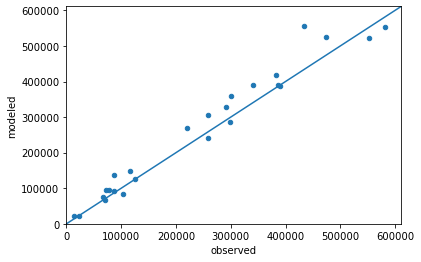

In [11]:
df = df.head(-1)
ax = df.plot(kind='scatter', x='observed', y='modeled')
lim = df[['observed','modeled']].max().max()*1.05
ax.set_ylim(0,lim)
ax.set_xlim(0,lim)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x)
slope, intercept, r_value, p_value, std_err = stats.linregress(df['observed'],df['modeled'])
print('r^2 : ' + str(r_value))